## Лабораторная работа 5. Часть 2.

In [52]:
import numpy as np
import pandas as pd
import scipy
import scipy.stats as sps

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, fbeta_score, roc_curve, precision_recall_curve, auc, 
    average_precision_score
)

from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
sns.set_style("dark")
sns.set(font_scale=1.6)

## Задача 1

Реализуйте логистическую регрессию с $\ell_2$ регуляризацией для поиска оценки параметров с помощью стохастического mini-batch градиентного спуска (SGD).

In [40]:
class LogisticRegression():
    '''
    Модель логистической регрессии. Имеет следующие гиперпараметры:

    :param alpha: параметр регуляризации. 
                  Если равно 0, то регуляризация не происходит.
    :param lr: константа, на которую домножаем градиент при обучении
    :param max_iter: ограничение на кол-во итераций
    :param fit_intercept: указывает, следует ли добавить константу в признаки
    :param batch_size: размер батча
    '''

    def __init__(self, alpha=0, lr=0.5, max_iter=1e5,
                 fit_intercept=True, batch_size=30):
        '''Создает модель и инициализирует параметры.'''

        self.alpha = alpha
        self.lr = lr
        self.max_iter = max_iter
        self.fit_intercept = fit_intercept
        self.batch_size = batch_size

    @staticmethod
    def _sigmoid(x):
        return scipy.special.expit(x)
    
    def _grad_fit_int(self, X, Y, W, lam):
        res = X.T.dot(Y - self._sigmoid(X.dot(W))) - 2 * lam * W
        res[-1] = res[-1] + 2 * lam * W[-1]
        return res
    
    def _grad(self, X, Y, W, lam):
        return X.T.dot(Y - self._sigmoid(X.dot(W))) - 2 * lam * W

    def _add_intercept(self, X):
        '''
        Добавляем свободный коэффициент к нашей модели. 
        Это происходит путем добавления вектора из 1 к исходной матрице.

        :param X: исходная матрица признаков
        :return: матрица X с добавленным свободным коэффициентов
        '''

        X_copy = np.full((X.shape[0], X.shape[1] + 1), fill_value=1)
        X_copy[:, :-1] = X

        return X_copy

    def fit(self, X, Y):
        '''
        Обучает модель логистической регресии с помощью SGD,
        пока не выполнится self.max_iter итераций.

        :param X: матрица признаков
        :param Y: истинные метки
        '''

        assert X.shape[0] == Y.shape[0]

        if self.fit_intercept:  # добавляем свободный коэфициент
            X_copy = self._add_intercept(X)
        else:
            X_copy = X.copy()

        d = X_copy.shape[1]
        n = Y.shape[0]
        result_W = np.ones(d)
        
        iteration = 0
        while iteration < self.max_iter:
            iteration += 1
            indexes = np.random.randint(0, n, self.batch_size)
            if self.fit_intercept:
                to_sum = self._grad_fit_int(X_copy[indexes], Y[indexes], result_W, self.alpha)
            else:
                to_sum = self._grad(X_copy[indexes], Y[indexes], result_W, self.alpha)
            result_W = result_W + self.lr * n * to_sum / self.batch_size

        self.coef_ = result_W[:-1] if self.fit_intercept else result_W  # коэффициенты модели
        self.intercept_ = result_W[-1] if self.fit_intercept else 0 # свободный коэффициент
        self.weights = result_W
        #print(self.weights.shape[0])
        return self

    def predict(self, X):
        '''
        Применяет обученную модель к данным 
        и возвращает точечное предсказание (оценку класса).

        :param X: матрица признаков
        :return: предсказание с размерностью (n_test, )
        '''

        if self.fit_intercept:
            X_copy = self._add_intercept(X)
        else:
            X_copy = X.copy()

        assert X_copy.shape[1] == self.weights.shape[0]

        proba = self._sigmoid(X_copy.dot(self.weights))
        predictions = 1 * (proba > 0.5)

        return predictions

    def predict_proba(self, X):
        '''
        Применяет обученную модель к данным
        и возвращает предсказание вероятности классов 0 и 1.

        :param X: матрица признаков
        :return: вероятности предсказания с размерностью (n_test, 2)
        '''

        if self.fit_intercept:
            X_copy = self._add_intercept(X)
        else:
            X_copy = X.copy()

        assert X_copy.shape[1] == self.weights.shape[0]

        prob_predictions = _sigmoid(X_copy.dot(self.weights))

        return prob_predictions

Рассмотрим игрушечный датасет на $30$ признаков `load_breast_cancer` из библиотеки `sklearn`. Это относительно простой для бинарной классификации датасет по диагностике рака молочной железы.

Ради интереса можно прочитать описание признаков.

In [3]:
dataset = load_breast_cancer()
dataset['DESCR'].split('\n')[11:31]

['    :Attribute Information:',
 '        - radius (mean of distances from center to points on the perimeter)',
 '        - texture (standard deviation of gray-scale values)',
 '        - perimeter',
 '        - area',
 '        - smoothness (local variation in radius lengths)',
 '        - compactness (perimeter^2 / area - 1.0)',
 '        - concavity (severity of concave portions of the contour)',
 '        - concave points (number of concave portions of the contour)',
 '        - symmetry',
 '        - fractal dimension ("coastline approximation" - 1)',
 '',
 '        The mean, standard error, and "worst" or largest (mean of the three',
 '        worst/largest values) of these features were computed for each image,',
 '        resulting in 30 features.  For instance, field 0 is Mean Radius, field',
 '        10 is Radius SE, field 20 is Worst Radius.',
 '',
 '        - class:',
 '                - WDBC-Malignant',
 '                - WDBC-Benign']

Разделим нашу выборку на обучающую и тестовую:

In [4]:
X, Y = dataset['data'], dataset['target']

X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((455, 30), (114, 30), (455,), (114,))

При использовании регуляризации данные необходимо нормализовать. Воспользуемся для этого классом `StandardScaler` из библиотеки `sklearn`. 

In [5]:
scaler = StandardScaler()

Теперь обучите модель логистической регрессии.

In [41]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [42]:
log_reg = LogisticRegression()
log_reg.fit(X_train, Y_train)

In [43]:
Y_predict = log_reg.predict(X_test)

In [54]:
matrix = confusion_matrix(Y_test, Y_predict)
(TN, FP), (FN, TP) = matrix
print(f'TN = {TN}')
print(f'FP = {FP}')
print(f'FN = {FN}')
print(f'TP = {TP}')

TN = 35
FP = 8
FN = 5
TP = 66


In [55]:
recall = recall_score(Y_test, Y_predict)
print(f'Recall = {recall:.3f}')

Recall = 0.930


In [56]:
precision = precision_score(Y_test, Y_predict)
print(f'Precision = {precision:.3f}')

Precision = 0.892


На занятии обсуждали, что в нашей постановке задачи при сравнении выиграет модель с меньшим FN, ведь каждая не обнаруженная опухоль может стоить человеческой жизни. Чем меньше ложно отрицательных срабатываний, тем выше Recall модели, а значит разумно взять Recall в качестве целевой метрики. 

Построить модель с Recall = 1 довольно просто (Как?), но в ней не будет большого смысла, т.к., например, для нашей задачи отправление на доп. обследование может стоить дополнительных средств и времени специалистов, поэтому хотелось, чтобы наша модель имела неплохую точность. Какую метрику можно использовать, чтобы учесть и точность, и полноту?

Будем использовать $F_3$-метрику, так как мы хотим учесть и точность, и полноту, но при этом полнота важнее.

Выберите и посчитайте целевые метрики для нашей задачи.

In [71]:
fbeta = fbeta_score(Y_test, Y_predict, beta=3)
print(f'FBeta-score (beta=3): {fbeta:.3f}')

FBeta-score (beta=3): 0.926


Рассмотрите как влияет размер шага (`learning rate`) на качество модели. Обучите каждую модель одинаковое число итераций (например, 10000), а затем посчитайте качество. Сделайте выводы.

In [72]:
lrs = [1e-5, 1e-4, 1e-3, 1e-2, 0.1, 0.2, 0.3, 0.5, 0.7, 1, 2, 5, 10]

In [73]:
for lr in lrs:
    clf = LogisticRegression(lr=lr, max_iter=1e4)
    clf.fit(X_train, Y_train)
    print(f'{lr}: {fbeta_score(Y_test, clf.predict(X_test), beta=3):.3f}')

1e-05: 0.987
0.0001: 0.976
0.001: 0.978
0.01: 0.979
0.1: 0.852
0.2: 0.915
0.3: 0.914
0.5: 0.914
0.7: 0.900
1: 0.915
2: 0.914
5: 0.962
10: 0.914


Рассмотрите несколько моделей, в которых установите не менее 5-ти различных коэффициентов регуляризации, а также модель без регуляризатора. Сравните, влияет ли наличие регуляризации на качество, сделайте выводы. Под качеством подразумевается значение какой-либо выбранной вами метрики качества классификации.

In [74]:
# массивы для результатов
fbeta_values = []

k = 10  # будем усреднять результаты по нескольким запускам
coefs = [0]
coefs.extend(np.logspace(-5, 3, 9))  # сетка параметров регуляризации

for coef in coefs:
    fbeta_values_tmp = []

    # k раз обучаем модель и считаем среднее целевых метрик.
    for i in range(k):
        clf = LogisticRegression(alpha=coef, max_iter=1e4)
        clf.fit(X_train, Y_train)

        fbeta_values_tmp.append(
            fbeta_score(Y_test, clf.predict(X_test), beta=3)
        )

    fbeta_values.append(np.mean(fbeta_values_tmp))

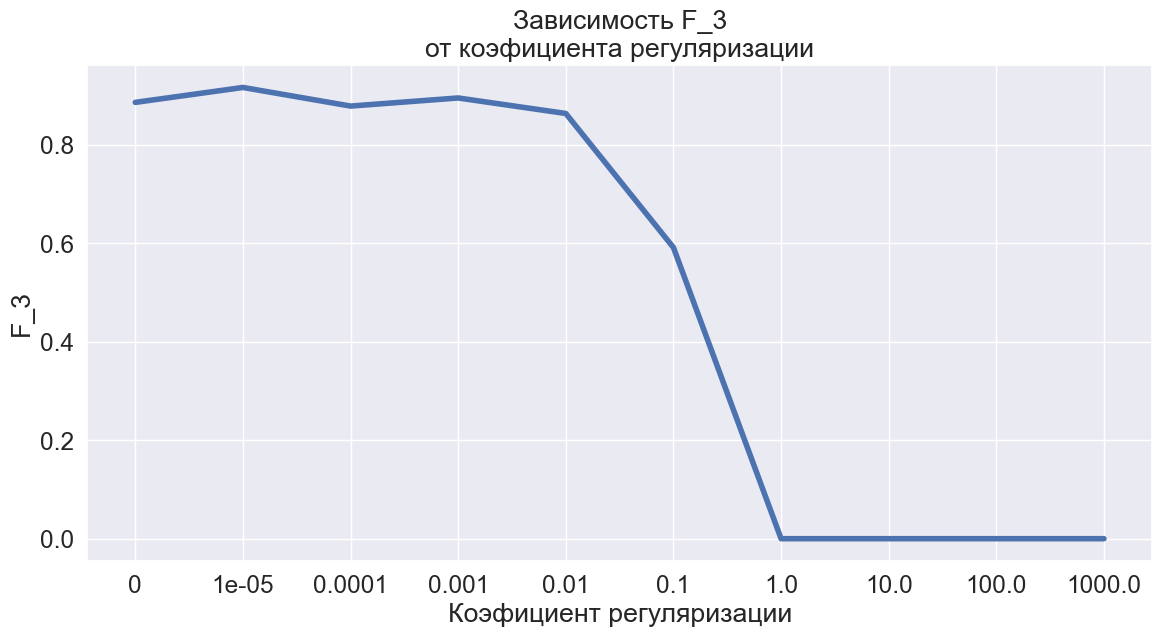

In [76]:
plt.figure(figsize=(12, 12))

plt.subplot(2, 1, 1)
plt.title('Зависимость F_3\nот коэфициента регуляризации')
plt.plot(fbeta_values, lw=4)
plt.xlabel('Коэфициент регуляризации')
plt.ylabel('F_3')
plt.xticks(ticks=np.arange(len(coefs)), labels=coefs)
plt.grid()

plt.tight_layout()
plt.grid()
plt.show()

Видно, что коэффициент регуляризации, больший $10^{-3}$ ухудшает показатели $F_3$-метрики.

Выберите объект из тестовой выборки и постройте для него доверительный интервал для предсказания вероятности. Какие условия нужно проверить? 

In [ ]:
<...>

**Вывод:** <...>